In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from sklearn.impute import SimpleImputer

from tensorflow.keras.callbacks import EarlyStopping
import pickle
from tensorflow.keras.layers import Conv3D, MaxPool3D, Flatten, Dense, ReLU, AveragePooling3D, LeakyReLU, Add
from tensorflow.keras import regularizers

2024-07-24 15:27:45.582392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 15:27:45.805543: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
tf.random.set_seed(1)
import random

import os
random.seed(1)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from sklearn.impute import SimpleImputer

import os
from os import listdir
from os.path import isfile, join

#from keras.engine.topology import Layer
from keras.layers import Activation, Lambda, Conv1D, SpatialDropout1D, add
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, concatenate
from tensorflow.keras.models import Model
from sklearn.impute import KNNImputer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Flatten, Dense, Input
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adadelta, Adam, SGD, Nadam
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [4]:
from keras import initializers

np.random.seed(16)
tf.random.set_seed(16)
from sklearn.preprocessing import OneHotEncoder


In [5]:
model_file_path = "/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/"
model_name = "cnn_1d_binaryClassifier.h5"
model_regressed = "mlp_regressed_cnn_output.h5"

cnn_model_path = model_file_path + model_name
regressed_model_path = model_file_path + model_regressed

In [6]:
classes = 3

In [7]:
def fix_geno_file(geno_file,classes, same_SNPs_list):
    geno_df = pd.read_csv(geno_file,sep="\t",index_col=2)
    geno_df = geno_df.drop(columns=['#CHROM','POS','REF','ALT','QUAL','FILTER','INFO','FORMAT'])
    print(geno_df.shape)
    
    geno_df_filtered = geno_df[geno_df.index.isin(same_SNPs_list)]
    
    dataframe_T = geno_df_filtered.T
    print(dataframe_T.shape)
    SNPs = len(dataframe_T.columns) #-1 # only drop one when its a revalued vcf file!!
    # Impute with KNN/ Simple
    SI = SimpleImputer(missing_values=9, strategy='most_frequent')
    #knn_imputer = KNNImputer(missing_values='9',n_neighbors=100, weights='uniform', metric='nan_euclidean')
    tmp = SI.fit_transform(dataframe_T)
    dataframe_T_imputed = pd.DataFrame(tmp, columns = dataframe_T.columns, index = dataframe_T.index)
    
    categories = [np.array([0, 1, 2])]*SNPs
    encoder = OneHotEncoder(categories=categories,sparse_output=False)
    data_encoded = encoder.fit_transform(dataframe_T_imputed.to_numpy())
    #print(data_encoded.shape)
    #data_encoded = data_encoded.toarray()
    data_encoded = data_encoded.reshape(-1, 1)
    list_ID = list(dataframe_T_imputed.index.values)
    data_encoded = data_encoded.reshape((len(list_ID),SNPs, classes))
    print(data_encoded.shape)
    
    #list_ID = list(dataframe_T_imputed.index.values) 
    return SNPs, list_ID, data_encoded



In [8]:
def fix_geno_file_noOHE(geno_file, same_SNPs_list):
    geno_df = pd.read_csv(geno_file,sep="\t",index_col=2)
    geno_df = geno_df.drop(columns=['#CHROM','POS','REF','ALT','QUAL','FILTER','INFO','FORMAT'])
    print(geno_df.shape)
    
    geno_df_filtered = geno_df[geno_df.index.isin(same_SNPs_list)]
    
    dataframe_T = geno_df_filtered.T
    print(dataframe_T.shape)
    SNPs = len(dataframe_T.columns) #-1 # only drop one when its a revalued vcf file!!
    # Impute with KNN/ Simple
    SI = SimpleImputer(missing_values=9, strategy='most_frequent')
    #knn_imputer = KNNImputer(missing_values='9',n_neighbors=100, weights='uniform', metric='nan_euclidean')
    tmp = SI.fit_transform(dataframe_T)
    dataframe_T_imputed = pd.DataFrame(tmp, columns = dataframe_T.columns, index = dataframe_T.index)
    np_T_imputed = dataframe_T_imputed.to_numpy()
    #categories = [np.array([0, 1, 2])]*SNPs
    #encoder = OneHotEncoder(categories=categories,sparse_output=False)
    #data_encoded = encoder.fit_transform(dataframe_T_imputed.to_numpy())
    #print(data_encoded.shape)
    #data_encoded = data_encoded.toarray()
    #data_encoded = data_encoded.reshape(-1, 1)
    list_ID = list(dataframe_T_imputed.index.values)
    data_encoded = np_T_imputed.reshape((len(list_ID),SNPs, 1))
    print(data_encoded.shape)
    
    #list_ID = list(dataframe_T_imputed.index.values) 
    return SNPs, list_ID, data_encoded, dataframe_T_imputed

In [9]:
def read_in_popStruc(popStruc_file,list_ID):
    pop_struc = pd.read_csv(popStruc_file,sep="\t", header=0, index_col=1)
    pop_struc = pop_struc.drop(columns=['FIID'])
    
    list_ID_pop = list(pop_struc.index.values)
    merged_list = list(set(list_ID_pop) & set(list_ID))
    
    s = set(merged_list)
    temp3 = [x for x in list_ID if x not in s]
    
    #pop_struc = pop_struc[pop_struc['IID'].isin(list_ID)]
    pop_struc = pop_struc.loc[merged_list]
    #print(pop_struc[:10].head)
    print(pop_struc.shape)
    return pop_struc, temp3

In [10]:
def drop_missing(pids, list_ID, data):
    list_ID_new = list_ID
    print(data.shape)
    for i in pids:
        # Find index of patient ID to drop
        index_to_drop = list_ID.index(i)
        print(i," ",index_to_drop)

        # Drop the respective index from the numpy array
        data_new = np.delete(data, index_to_drop, axis=0)
        
        list_ID_new.remove(i)
        
        print(data_new.shape)
        print(len(list_ID_new))
        
    return data_new, list_ID_new

In [11]:
def reorder(pop_struc,list_ID):
    pop_struc = pop_struc.loc[lst]
    return pop_struc

In [12]:
def geno_cnn_big(inputLayer):
    # Input layer
    #input_layer = Input(shape=(46314, 1))

    # Convolutional layers (FOR BIGGER SNPS DIM)
    conv1 = Conv1D(filters=16, kernel_size=31, activation='relu',name="conv1G")((inputLayer[0]))
    batch_norm1 = BatchNormalization()(conv1)
    max_pooling1 = MaxPooling1D(pool_size=6,name="pool1G")(batch_norm1) #10

    conv2 = Conv1D(filters=32, kernel_size=15, activation='relu', kernel_regularizer=regularizers.l2(0.01),name="conv2G")(max_pooling1)
    batch_norm2 = BatchNormalization()(conv2)
    max_pooling2 = MaxPooling1D(pool_size=3,name="pool2G")(batch_norm2) #6

    #conv3 = Conv1D(filters=64, kernel_size=15, activation='relu',name="conv3G")(max_pooling2)
    #max_pooling3 = MaxPooling1D(pool_size=4, name="pool3G")(conv3)

    #conv4 = Conv1D(filters=128, kernel_size=15, name="conv4G")(max_pooling2)
    #batch_norm4 = BatchNormalization()(conv4)

    # Flatten layer
    flatten = Flatten()(max_pooling2)

    # Dense layers
    dense1 = Dense(512, activation='relu')(flatten)
    x = Dense(256, activation='relu')(dense1)#()
    x = Dropout(.2)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    return output_layer
    #return flatten

In [13]:
def geno_big_mlp(inputLayer):
    flatten = Flatten()

In [14]:
def geno_cnn_small(inputLayer):
    # Input layer
    #input_layer = Input(shape=(46314, 1))

    # Convolutional layers
    conv1 = Conv1D(filters=16, kernel_size=3, activation='relu',name="conv1G")((inputLayer[0]))
    batch_norm1 = BatchNormalization()(conv1)
    max_pooling1 = MaxPooling1D(pool_size=4,name="pool1G")(batch_norm1)

    conv2 = Conv1D(filters=32, kernel_size=3, activation='relu',name="conv2G")(max_pooling1)
    batch_norm2 = BatchNormalization()(conv2)
    max_pooling2 = MaxPooling1D(pool_size=3,name="pool2G")(batch_norm2)


    # Flatten layer
    flatten = Flatten()(max_pooling2)

    # Upsampling
    reshaped = Reshape((-1, 1))(flatten)
    upsampled = UpSampling1D(size=2)(reshaped)
    flatten = Flatten(name="flattenUpsample")(upsampled)

    # Dense layers
    dense1 = Dense(28, activation='relu')(flatten)
    #dropped = Dropout(.2)(dense1)
    output_layer = Dense(1, activation='sigmoid')(dense1)
    return output_layer

In [15]:
def compile_model(SNPs,classes):
    opt = Adam(lr=0.001)#,decay=1e-6)
    
    metr = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
    
    inputA = Input(shape=(SNPs,classes),name="InputA")

    y = geno_cnn_big([inputA])

    model = Model(inputs=[inputA], outputs=[y])
    model.summary()
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=metr)
    
    return model

In [16]:
def scheduler(epoch, lr):
    #return lr * tf.math.exp(-0.1)
    decay_rate = 0.1
    decay_step = 10  # adjust as needed
    return lr * tf.math.exp(-decay_rate * epoch / decay_step)

In [17]:
def intermediate_model(layer, model):
    layer_output = model.get_layer(layer).output
    model = tf.keras.models.Model(inputs=model.input, outputs=layer_output)
    model.summary()
    return model

In [18]:
def get_outputs(model,data):
    features = model.predict(data)
    print(features.shape)
    return features

In [19]:
def binary_predictor_model(flatten_feature_size):
    # Binary Predictor Model
    input_layer_bp = layers.Input(shape=(flatten_feature_size, 1))  
    flatten = Flatten()(input_layer_bp)
    #dense5 = layers.Dense(600, activation='relu')(input_layer_bp)
    #dense6 = layers.Dense(512,activation='relu')(input_layer_bp)
    #dense7 = layers.Dense(256,activation='relu')(dense6)
    #max_pooling = layers.MaxPooling1D(pool_size=6)(dense6)
    
    
    # Dense layers
    x = Dense(512, activation='relu')(flatten)
    x = Dense(256, activation='relu')(x)#()
    x = Dropout(.2)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    
    #output_layer_bp = layers.Dense(1, activation='sigmoid')(dense7)


    binary_predictor_model = Model(input_layer_bp, output_layer, name="binary_predictor")
    binary_predictor_model.summary()
    
    opt = Adam(lr=0.0001)#,decay=1e-6)
    metr = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
    binary_predictor_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=metr)
    
    return binary_predictor_model

In [20]:
def binary_predictor_model_noOHE(flatten_feature_size):
    # Binary Predictor Model
    input_layer_bp = layers.Input(shape=(flatten_feature_size))  
    #flatten = Flatten()(input_layer_bp)
    #dense5 = layers.Dense(600, activation='relu')(input_layer_bp)
    #dense6 = layers.Dense(512,activation='relu')(input_layer_bp)
    #dense7 = layers.Dense(256,activation='relu')(dense6)
    #max_pooling = layers.MaxPooling1D(pool_size=6)(dense6)
    
    
    # Dense layers
    #x = Dense(1024, activation='relu')(input_layer_bp)
    #x = Dropout(.2)(x)
    x = Dense(512, activation='relu')(input_layer_bp)
    x = Dense(256, activation='relu')(x)#()
    x = Dropout(.2)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    
    #output_layer_bp = layers.Dense(1, activation='sigmoid')(dense7)


    binary_predictor_model = Model(input_layer_bp, output_layer, name="binary_predictor")
    binary_predictor_model.summary()
    
    opt = Adam(lr=0.00001)#,decay=1e-6)
    metr = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
    binary_predictor_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=metr)
    
    return binary_predictor_model

In [22]:
# def drop_index(PIDs_to_drop, list_ID, geno_df):
#     for i in PIDs_to_drop:
#         index_to_drop = list_ID.index(PID)
#         geno_df = np.delete(geno_df, index_to_drop, axis=0)
#     print("New Geno Shape: ", geno_df.shape)
#     return geno_df

In [21]:
def convert_preds(test_data, model):
    predictions = model.predict(test_data)
    predictions[predictions < 0.5] = 0
    predictions[predictions > 0.5] = 1
    print(predictions)
    return predictions

In [22]:
def my_confusion_matrix(y_test, predictions):

    accuracy = accuracy_score(y_test, predictions)
    confusion_mat = confusion_matrix(y_test, predictions)
    classification_rep = classification_report(y_test, predictions)

    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", confusion_mat)
    print("Classification Report:\n", classification_rep)

In [23]:
def generate_labels(list_ids_cases, list_ids_controls):
    labels_cases = np.ones(len(list_ids_cases))
    labels_controls = np.zeros(len(list_ids_controls))
    return np.concatenate((labels_cases, labels_controls))


In [24]:
def split_data(list_ids_cases, list_ids_controls, data_cases, data_controls, test_size=0.3, valid_size=0.5, random_state=None):
    # Generate labels
    labels = generate_labels(list_ids_cases, list_ids_controls)
    
    # Combine cases and controls data
    X_combined = np.concatenate((data_cases, data_controls), axis=0)
    list_ids_combined = list_ids_cases + list_ids_controls
    print(len(list_ids_combined))
    
    # Splitting into train, test, and validation sets
    X_train, X_tmp, y_train, y_tmp, ids_train, ids_tmp = train_test_split(X_combined, labels, list_ids_combined, test_size=test_size, random_state=random_state, shuffle=True, stratify=labels)
    print(X_train.shape)
    X_test, X_valid, y_test, y_valid, ids_test, ids_valid = train_test_split(X_tmp, y_tmp, ids_tmp, test_size=valid_size, random_state=random_state, shuffle=True, stratify=y_tmp)
    print(X_test.shape)
    
    return X_train, X_test, X_valid, y_train, y_test, y_valid, ids_train, ids_test, ids_valid

In [25]:

def split_data_race(df, list_ids_cases, list_ids_controls, data_cases, data_controls, test_size=0.3, valid_size=0.5, random_state=None):
    # Generate labels for disease
    disease_labels = generate_labels(list_ids_cases, list_ids_controls)

    # Combine cases and controls data
    X_combined = np.concatenate((data_cases, data_controls), axis=0)
    list_ids_combined = list_ids_cases + list_ids_controls
    print(len(list_ids_combined))

    # Splitting into train, test, and validation sets using disease labels
    X_train, X_tmp, disease_y_train, disease_y_tmp, ids_train, ids_tmp = train_test_split(
        X_combined, disease_labels, list_ids_combined, test_size=test_size, random_state=random_state, shuffle=True, stratify=disease_labels
    )
    print(X_train.shape)
    X_test, X_valid, disease_y_test, disease_y_valid, ids_test, ids_valid = train_test_split(
        X_tmp, disease_y_tmp, ids_tmp, test_size=valid_size, random_state=random_state, shuffle=True, stratify=disease_y_tmp
    )
    print(X_test.shape)

    # Map IDs to race labels
    id_to_race = dict(zip(df['IID'], df['white']))
    race_y_train = np.array([id_to_race[id_] for id_ in ids_train])
    race_y_test = np.array([id_to_race[id_] for id_ in ids_test])
    race_y_valid = np.array([id_to_race[id_] for id_ in ids_valid])

    return X_train, X_test, X_valid, race_y_train, race_y_test, race_y_valid, ids_train, ids_test, ids_valid


In [26]:
def get_SNPs_merge(geno_file_1,geno_file_0):
    geno_df_1 = pd.read_csv(geno_file_1,sep="\t",index_col=2)
    geno_df_1 = geno_df_1.drop(columns=['#CHROM','POS','REF','ALT','QUAL','FILTER','INFO','FORMAT'])
    list_1 = list(geno_df_1.index.values)
    
    
    geno_df_0 = pd.read_csv(geno_file_0,sep="\t",index_col=2)
    geno_df_0 = geno_df_0.drop(columns=['#CHROM','POS','REF','ALT','QUAL','FILTER','INFO','FORMAT'])
    list_0 = list(geno_df_0.index.values)
    
    join_snps = list(set(list_0).intersection(list_1))
    
    return join_snps
    
    

In [27]:
def split_popStruc(ids_train, ids_test, ids_valid, pop_struc_1,pop_struc_0):
    frames = [pop_struc_1, pop_struc_0]
    result = pd.concat(frames)
    #popStruc_combined = np.concatenate((pop_struc_0,pop_struc_1),axis=0)
    
    train_pop_struc = result.loc[ids_train]
    test_pop_struc = result.loc[ids_test]
    valid_pop_struc = result.loc[ids_valid]
    
    return train_pop_struc,test_pop_struc,valid_pop_struc
    

In [28]:
def save_resids(data,ids,filename):
    resid_train = pd.DataFrame(data, index=ids)
    resid_train.to_csv(filename, index_label='ID')
    print("Saved: ",filename)

In [29]:
def save_split(data, ids, labels, filename):
    # Create DataFrame for residuals data
    #snps = pd.DataFrame(data, index=ids, columns=['Residuals'])

    # Create DataFrame for additional array data
    additional_df = pd.DataFrame({'label': labels}, index=ids)

    # Concatenate DataFrames along columns
    #merged_df = pd.concat([snps, additional_df], axis=1)

    # Save merged DataFrame to CSV
    additional_df.to_csv(filename, index_label='ID')

    print("Saved:", filename)

In [30]:
def plot_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)

    # Plotting the training and validation loss
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [31]:
# Define a function to get the gradients of the output with respect to the input
@tf.function
def get_gradients(model, inputs):
    with tf.GradientTape() as tape:
        inputs = tf.convert_to_tensor(inputs)
        tape.watch(inputs)
        predictions = model(inputs)
    grads = tape.gradient(predictions, inputs)
    return grads

# Define a function to calculate Grad-CAM for a 1D input vector
def calculate_grad_cam_1d(model, inputs, class_idx):
    grads = get_gradients(model, inputs)
    pooled_grads = tf.reduce_mean(grads, axis=0)
    cam = pooled_grads * inputs
    return cam.numpy()

In [32]:
def plot_gradCam(test_data_features, y_test, sample_id, loaded_model, dirname='/media/gdagasso/TOSHIBA EXT/ABCD/popStruc_figs'):
    # Prepare a sample input (adjust as needed)
    sample_input = test_data_features[sample_id:sample_id+1].astype(np.float32)

    # Choose a class index for which you want to compute Grad-CAM (0 or 1 for binary classification)
    class_index = y_test[sample_id:sample_id+1]
    print(class_index)

    # Compute Grad-CAM for the 1D input vector
    grad_cam = calculate_grad_cam_1d(loaded_model, sample_input, class_index)

    # Visualize the Grad-CAM heatmap (1D signal)
    plt.figure(figsize=(10, 3))
    plt.plot(abs(grad_cam[0]))
    plt.xlabel('Variant Position')
    plt.ylabel('|Grad-CAM Value|')

    # Construct the plot filename with class index and participant ID
    plot_filename = os.path.join(dirname, f"gradCam_class{class_index[0]}_participant{sample_id}_gradCAM.svg")
    plt.savefig(plot_filename)
    plt.show()

    print(sample_input.shape)
    print(grad_cam.shape)  
    print(grad_cam)        
    
    return grad_cam


In [33]:
def plot_gradCam_average(test_data_features, y_test, label, loaded_model, output_to_flatten = False, dirname='/media/gdagasso/TOSHIBA EXT/ABCD/popStruc_figs'):
    # Filter samples based on the label
    indices = np.where(y_test == label)[0]
    if len(indices) == 0:
        print(f"No samples found with label {label}")
        return

    # Prepare the input data for the selected samples
    #sample_inputs = test_data_features[indices].astype(np.float32)
    #print(sample_inputs.shape)

    # Compute Grad-CAM for each input sample
    grad_cams = []
    if not output_to_flatten:
        for index in indices:
            sample_input = test_data_features[index:index+1].astype(np.float32)
            # Compute Grad-CAM for the 1D input vector
            class_index = np.array([[label]])  # Class index for binary classification
            grad_cam = calculate_grad_cam_1d(loaded_model, sample_input, class_index)
            grad_cams.append(grad_cam)
    else:
        sample_inputs = test_data_features[indices].astype(np.float32)
        #print(sample_inputs.shape)
        
        for sample_input in sample_inputs:
            #print(sample_input.shape)
            reshaped_sample = sample_input.reshape(1, -1)
            #print(reshaped_sample.shape)
            # Compute Grad-CAM for the 1D input vector
            class_index = np.array([[label]])  # Class index for binary classification
            grad_cam = calculate_grad_cam_1d(loaded_model, reshaped_sample, class_index)
            grad_cams.append(grad_cam)

    # Average the Grad-CAM values over all samples
    avg_grad_cam = np.mean(grad_cams, axis=0)

    # Visualize the averaged Grad-CAM heatmap (1D signal)
    plt.figure(figsize=(10, 3))
    plt.plot(avg_grad_cam[0])
    plt.title(f'Averaged Grad-CAM Heatmap for Label {label} (1D Signal)')
    plt.xlabel('Input Position')
    plt.ylabel('Average Grad-CAM Value')
    # Construct the plot filename with class index and participant ID
    plot_filename = os.path.join(dirname, f"gradCam_class{label}_gradCAM_average_nonABS.svg")
    plt.savefig(plot_filename)
    plt.show()

    return avg_grad_cam


In [34]:
def norm(data):
    return (data)/(max(data)-min(data))

In [35]:
def plot_gradCam_ind_overlay(test_data_features1, test_data_features2, y_test, sample_id, loaded_model1, loaded_model2,dirname='/media/gdagasso/TOSHIBA EXT/ABCD/popStruc_figs'):
    # Prepare sample inputs for both versions (adjust as needed)
    sample_input1 = test_data_features1[sample_id:sample_id+1].astype(np.float32)
    sample_input2 = test_data_features2[sample_id:sample_id+1].astype(np.float32)

    # Choose a class index for which you want to compute Grad-CAM (0 or 1 for binary classification)
    class_index = y_test[sample_id:sample_id+1]

    # Compute Grad-CAM for the 1D input vector for both models and versions
    grad_cam1 = calculate_grad_cam_1d(loaded_model1, sample_input1, class_index)
    grad_cam2 = calculate_grad_cam_1d(loaded_model2, sample_input2, class_index)

    # Visualize the Grad-CAM heatmaps (1D signals) from both models and versions
    plt.figure(figsize=(10, 6))
    plt.plot(norm(abs(grad_cam1[0])), label='Non-regressed input')
    plt.plot(norm(abs(grad_cam2[0])), label='Regressed input')
    plt.xlabel('Variant Position')
    plt.ylabel('|Grad-CAM Value|')
    plt.legend()
    # Construct the plot filename with class index and participant ID
    plot_filename = os.path.join(dirname, f"gradCam_class{class_index[0]}_participant{sample_id}_gradCAM_ind_overlay_input.svg")
    plt.savefig(plot_filename)
    plt.show()

    return grad_cam1, grad_cam2


In [36]:
def plot_gradCam_average_manPlot(test_data_features, y_test, label, loaded_model, output_to_flatten = False, dirname='/media/gdagasso/TOSHIBA EXT/ABCD/popStruc_figs'):
    # Filter samples based on the label
    indices = np.where(y_test == label)[0]
    if len(indices) == 0:
        print(f"No samples found with label {label}")
        return

    # Prepare the input data for the selected samples
    #sample_inputs = test_data_features[indices].astype(np.float32)
    #print(sample_inputs.shape)

    # Compute Grad-CAM for each input sample
    grad_cams = []
    if not output_to_flatten:
        for index in indices:
            sample_input = test_data_features[index:index+1].astype(np.float32)
            # Compute Grad-CAM for the 1D input vector
            class_index = np.array([[label]])  # Class index for binary classification
            grad_cam = calculate_grad_cam_1d(loaded_model, sample_input, class_index)
            grad_cams.append(grad_cam)
    else:
        sample_inputs = test_data_features[indices].astype(np.float32)
        #print(sample_inputs.shape)
        
        for sample_input in sample_inputs:
            #print(sample_input.shape)
            reshaped_sample = sample_input.reshape(1, -1)
            #print(reshaped_sample.shape)
            # Compute Grad-CAM for the 1D input vector
            class_index = np.array([[label]])  # Class index for binary classification
            grad_cam = calculate_grad_cam_1d(loaded_model, reshaped_sample, class_index)
            grad_cams.append(grad_cam)

    # Average the Grad-CAM values over all samples
    avg_grad_cam = np.mean(grad_cams, axis=0)

    # Visualize the averaged Grad-CAM heatmap (1D signal)
    plt.figure(figsize=(10, 3))
    plt.plot(abs(avg_grad_cam[0]))
    #plt.title(f'Averaged Grad-CAM Heatmap for Label {label} (1D Signal)')
    plt.xlabel('Variant Position')
    plt.ylabel('|Average Grad-CAM Value|')
    plot_filename = os.path.join(dirname, f"gradCam_class{label}_gradCAM_manPlot.svg")
    plt.savefig(plot_filename)
    plt.show()

    return avg_grad_cam


In [37]:
def plot_gradCam_individual_scatter(test_data_features, y_test, label, loaded_model, output_to_flatten=False, dirname='/media/gdagasso/TOSHIBA EXT/ABCD/popStruc_figs'):
    # Filter samples based on the label
    indices = np.where(y_test == label)[0]
    if len(indices) == 0:
        print(f"No samples found with label {label}")
        return

    # Prepare the input data for the selected samples
    if output_to_flatten:
        sample_inputs = test_data_features[indices].astype(np.float32)
    else:
        sample_inputs = [test_data_features[index:index+1].astype(np.float32) for index in indices]

    # Compute Grad-CAM for each input sample
    grad_cams = []
    for sample_input in sample_inputs:
        # Compute Grad-CAM for the 1D input vector
        class_index = np.array([[label]])  # Class index for binary classification
        grad_cam = calculate_grad_cam_1d(loaded_model, sample_input, class_index)
        grad_cams.append(grad_cam)

    # Prepare scatter plot data
    variant_positions = np.arange(len(grad_cams[0][0]))  # Assuming all Grad-CAMs have the same length
    grad_cam_values = [abs(grad_cam[0]) for grad_cam in grad_cams]

    # Plot individual Grad-CAM values as scatter plot
    plt.figure(figsize=(10, 5))
    for i, grad_cam_value in enumerate(grad_cam_values):
        plt.scatter(variant_positions, grad_cam_value, label=f'Sample {indices[i]}', color='blue')

    plt.xlabel('Variant Position')
    plt.ylabel('|Grad-CAM Value|')
    plt.title(f'Individual Grad-CAM Values for Label {label}')
    #plt.legend()
    plot_filename = os.path.join(dirname, f"gradCam_class{label}_gradCAM_ind_scatter.svg")
    plt.savefig(plot_filename)
    plt.show()

    return grad_cam_values


In [38]:
def print_peaks(dataframe, grad_cam, threshold = 1.0e-07):
    max_index = np.argmax(grad_cam)
    print(max_index)

    grad_cam_flat = grad_cam.flatten()
    print(grad_cam_flat)
    abs_grad_cam_flat = np.absolute(grad_cam_flat)
    peaks, _ = find_peaks(abs_grad_cam_flat, height=threshold)  # Adjust the 'height' threshold as needed
    print("Peak Indices:", peaks)
    
    
    for peak_index in peaks:
        print("Peak Index:", peak_index)
        print("Column Name:", dataframe.columns[peak_index])
        print("Grad-CAM Value:", grad_cam_flat[peak_index])#iloc[:,peak_index])
    
    print("VEP:\n")
    for peak_index in peaks:
        print(dataframe.columns[peak_index])

In [39]:
def print_top_values(dataframe, grad_cam, top_n=500):
    grad_cam_flat = grad_cam.flatten()
    abs_grad_cam_flat = np.absolute(grad_cam_flat)

    # Get indices of top 500 values
    top_indices = np.argsort(abs_grad_cam_flat)[-top_n:]

    print("Top 500 Indices:", top_indices)

    # Print top 500 values
    print("Top 500 Values:")
    for index in top_indices:
        print("Column Name:", dataframe.columns[index])
        print("Grad-CAM Value:", grad_cam_flat[index])

    print("VEP:")
    for index in top_indices:
        print(dataframe.columns[index])


In [40]:
def log_reg_first_layer(X_train, X_test, X_valid, X_train_popStruc, X_test_popStruc, X_valid_popStruc):
    
    # REGRESSION

    # Residuals
    # Initialize empty arrays to store residuals
    resid_train = np.zeros_like(X_train)
    resid_test = np.zeros_like(X_test)
    resid_valid = np.zeros_like(X_valid)

    log_models = []


    # Loop through each feature in the features from flatten layer ie chr 5 flatten layer is 13504
    for i in range(X_train.shape[1]):
        #y = layers.Dense(units=20, activation="linear")(population_structure_input)

        # fit linear model for current feature[i]
        lm = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X_train_popStruc, X_train[:,i].ravel())

        # Save the linear model
        log_models.append(lm)

        # predict features explained by population structure
        p_train = lm.predict(X_train_popStruc)#train_data_all_r_features[:,i])
        p_test = lm.predict(X_test_popStruc)#test_data_all_r_features[:,i])
        p_valid= lm.predict(X_valid_popStruc)#valid_data_all_r_features[:,i])

        
        #print(p_train.shape)
        #print(X_train[:,i].shape)
        # calculate residuals 
        resid_train[:, i] =  X_train[:,i] - p_train.reshape(-1, 1)
        resid_test[:, i] =  X_test[:,i] - p_test.reshape(-1, 1)
        resid_valid [:, i]=  X_valid[:,i] - p_valid.reshape(-1, 1)
    
    return resid_train, resid_test, resid_valid, log_models

In [75]:
race_df = pd.read_csv("/home/gdagasso/ABCD/popStruc_AnomDetect_Datasets/IID_demo.csv")

In [76]:
geno_file_1 = "/media/gdagasso/TOSHIBA EXT/ABCD/fusionModels/ADHD/adhd/abcd_v3_qc_mind01_maf001_hwe0001_snpsOnly_adhd1_balanced_reValued_chr5.vcf"
geno_file_0 = "/media/gdagasso/TOSHIBA EXT/ABCD/fusionModels/ADHD/unaffected/abcd_v3_qc_mind01_maf001_hwe0001_snpsOnly_adhd0_balanced_reValued_chr5.vcf"

In [77]:
same_SNPs_list = get_SNPs_merge(geno_file_1,geno_file_0)

In [78]:
SNPs_1, list_ID_1, geno_df_1, df_1 = fix_geno_file_noOHE(geno_file_1, same_SNPs_list)#classes,
SNPs_0, list_ID_0, geno_df_0, df_0 = fix_geno_file_noOHE(geno_file_0, same_SNPs_list)#classes,

(25188, 708)
(708, 24262)
(708, 24262, 1)
(25019, 651)
(651, 24262)
(651, 24262, 1)


In [79]:
pop_struc_file ="/home/gdagasso/ABCD/popStruc_AnomDetect_Datasets/abcd_v3_qc_mind01_maf005_hwe0001_snpsOnly_wHeader.eigenvec"

In [80]:
pop_struc_1, missing_1 = read_in_popStruc(pop_struc_file, list_ID_1)
pop_struc_0, missing_0 = read_in_popStruc(pop_struc_file, list_ID_0)
print(missing_1)
print(missing_0)

(708, 20)
(650, 20)
[]
['NDAR_INV60WMW4VN']


In [81]:
print(pop_struc_1)

                       PC1       PC2       PC3       PC4       PC5       PC6  \
IID                                                                            
NDAR_INV4LVCVDEC  0.006346 -0.004133  0.000383  0.002954 -0.000701  0.002606   
NDAR_INVMVT25ECP  0.006177 -0.004644  0.000720 -0.004850  0.002122 -0.003096   
NDAR_INV2GDYKWG2  0.006876 -0.004105 -0.000611 -0.009977 -0.003463  0.021107   
NDAR_INVA05T670W  0.000945  0.017028  0.032584 -0.000073  0.007377  0.000736   
NDAR_INV1EZ26N40  0.005252 -0.001147 -0.001000 -0.004010  0.001610 -0.004628   
...                    ...       ...       ...       ...       ...       ...   
NDAR_INVWV58ZP6H  0.005778 -0.005393  0.000206  0.001524  0.003506  0.002705   
NDAR_INVHYRM141T  0.006469 -0.004213 -0.001489 -0.005582  0.000931  0.000181   
NDAR_INVCJ8FE0MN -0.020939 -0.005066 -0.000044  0.000704  0.001870 -0.000176   
NDAR_INV5CAVZWXG  0.006473 -0.004505 -0.000951 -0.006360  0.002327  0.013124   
NDAR_INV85UUUHN0  0.002935  0.001423 -0.

In [82]:
geno_df_0_dropped, list_ID_0_dropped = drop_missing(missing_0, list_ID_0, geno_df_0)

(651, 24262, 1)
NDAR_INV60WMW4VN   416
(650, 24262, 1)
650


# Split Data

In [57]:
# X_train, X_test, X_valid, y_train, y_test, y_valid, ids_train, ids_test, ids_valid = split_data(list_ID_1, list_ID_0_dropped, geno_df_1, geno_df_0_dropped, test_size=0.3, valid_size=0.5, random_state=None)

1358
(950, 24262, 1)
(204, 24262, 1)


In [65]:
# split on ADHD but have labels as white/other

In [83]:
X_train, X_test, X_valid, race_y_train, race_y_test, race_y_valid, ids_train, ids_test, ids_valid = split_data_race(race_df, list_ID_1, list_ID_0_dropped, geno_df_1, geno_df_0_dropped, test_size=0.3, valid_size=0.5, random_state=42)


1358
(950, 24262, 1)
(204, 24262, 1)


In [84]:
y_train = race_y_train
y_test = race_y_test
y_valid = race_y_valid

In [85]:
print(race_y_test)

[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1
 1 0 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0
 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1]


In [86]:
print(y_train.shape)

(950,)


In [51]:
# save_split(X_train,ids_train,y_train,"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/TRAIN_adhd_chr5_ids.csv")
# save_split(X_test,ids_test,y_test,"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/TEST_adhd_chr5_ids.csv")
# save_split(X_valid,ids_valid,y_valid,"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/VALID_adhd_chr5_ids.csv")


In [87]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(y_valid, return_counts=True)
print(dict(zip(unique, counts)))

{0: 221, 1: 729}
{0: 45, 1: 159}


In [88]:
print(X_train.shape)
print(y_train.shape)
#print(ids_train.shape)
#y_train = y_train.reshape(-1, 1)
#y_valid = y_valid.reshape(-1, 1)
#print(y_train.shape)

(950, 24262, 1)
(950,)


In [89]:
# popStruc
X_train_popStruc, X_test_popStruc, X_valid_popStruc = split_popStruc(ids_train, ids_test, ids_valid, pop_struc_1,pop_struc_0)

In [90]:
print(X_train_popStruc.shape)
print(X_test_popStruc.shape)

(950, 20)
(204, 20)


# Regress out

In [91]:
resid_train, resid_test, resid_valid, log_models = log_reg_first_layer(X_train, X_test, X_valid, X_train_popStruc, X_test_popStruc, X_valid_popStruc)

In [92]:
print(resid_test.shape)

(204, 24262, 1)


In [93]:
save_resids(np.squeeze(resid_train),ids_train,"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/resid_regressedAtInput_train_RACE.csv")
save_resids(np.squeeze(resid_test),ids_test,"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/resid_regressedAtInput_test_RACE.csv")
save_resids(np.squeeze(resid_valid),ids_valid,"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/resid_regressedAtInput_valid_RACE.csv")


Saved:  /media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/resid_regressedAtInput_train_RACE.csv
Saved:  /media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/resid_regressedAtInput_test_RACE.csv
Saved:  /media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/resid_regressedAtInput_valid_RACE.csv


# CNN nonregressed

In [94]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)


In [95]:
model = compile_model(len(same_SNPs_list),1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputA (InputLayer)         [(None, 24262, 1)]        0         
                                                                 
 conv1G (Conv1D)             (None, 24232, 16)         512       
                                                                 
 batch_normalization_4 (Batc  (None, 24232, 16)        64        
 hNormalization)                                                 
                                                                 
 pool1G (MaxPooling1D)       (None, 4038, 16)          0         
                                                                 
 conv2G (Conv1D)             (None, 4024, 32)          7712      
                                                                 
 batch_normalization_5 (Batc  (None, 4024, 32)         128       
 hNormalization)                                           

/home/gdagasso/anaconda3/envs/anomalyDetectionTF/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [96]:
model_file_path = "/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/"
model_name = "cnn_1d_binaryClassifier_noOHE_lr1e3_RACE"
model_regressed = "mlp_regressed_cnn_output_RACE.h5"

cnn_model_path = model_file_path + model_name
regressed_model_path = model_file_path + model_regressed

In [97]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 15:38:11


In [98]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{cnn_model_path}_epoch{{epoch}}_loss{{val_loss:.4f}}_acc{{val_accuracy:.4f}}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.h5"
                                                         , monitor='val_loss', verbose=2, save_best_only=True, include_optimizer=True, save_weights_only=False, mode='auto',
                                                         save_freq='epoch')

In [99]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define a learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Monitor validation loss
                              factor=0.2,          # Factor by which the learning rate will be reduced
                              patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
                              min_lr=0.00001)      # Lower bound on the learning rate


In [102]:
history = model.fit(X_train, y_train, batch_size = 10,epochs=120, validation_data=(X_valid,y_valid),
                    callbacks=[checkpoint_callback,reduce_lr,tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)], verbose=2) #lr_callback, checkpoint_callback, lr_callback tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),

Epoch 1/120

Epoch 1: val_loss did not improve from 0.37487
95/95 - 1s - loss: 0.0395 - accuracy: 0.9989 - precision: 0.9986 - recall: 1.0000 - val_loss: 0.4935 - val_accuracy: 0.9265 - val_precision: 0.9186 - val_recall: 0.9937 - lr: 4.0000e-05 - 529ms/epoch - 6ms/step
Epoch 2/120

Epoch 2: val_loss did not improve from 0.37487
95/95 - 0s - loss: 0.0422 - accuracy: 0.9979 - precision: 0.9986 - recall: 0.9986 - val_loss: 0.4880 - val_accuracy: 0.9265 - val_precision: 0.9186 - val_recall: 0.9937 - lr: 4.0000e-05 - 480ms/epoch - 5ms/step
Epoch 3/120

Epoch 3: val_loss did not improve from 0.37487
95/95 - 0s - loss: 0.0376 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4882 - val_accuracy: 0.9314 - val_precision: 0.9240 - val_recall: 0.9937 - lr: 4.0000e-05 - 479ms/epoch - 5ms/step
Epoch 4/120

Epoch 4: val_loss did not improve from 0.37487
95/95 - 0s - loss: 0.0386 - accuracy: 0.9989 - precision: 0.9986 - recall: 1.0000 - val_loss: 0.4895 - val_accuracy: 0.9314 - v

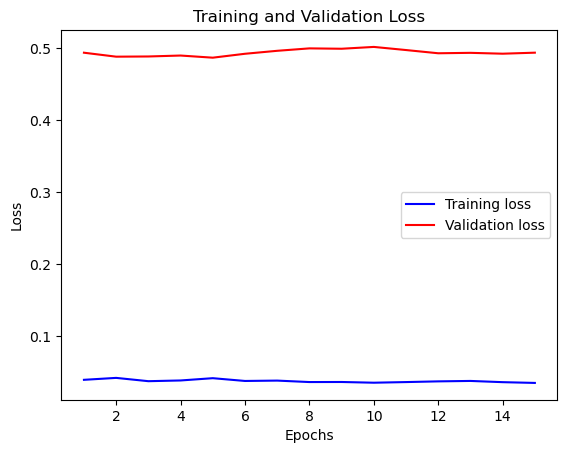

In [103]:
plot_loss(history)

In [106]:
from tensorflow.keras.models import load_model

loaded_model_input_nonRegress = load_model("/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_noOHE_lr1e3_RACE_epoch18_loss0.3749_acc0.9363_20240724_153811.h5")#"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier.h5_epoch4_loss0.7019_acc0.7647_20240214_191738.h5")
loaded_model_input_nonRegress.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputA (InputLayer)         [(None, 24262, 1)]        0         
                                                                 
 conv1G (Conv1D)             (None, 24232, 16)         512       
                                                                 
 batch_normalization_4 (Batc  (None, 24232, 16)        64        
 hNormalization)                                                 
                                                                 
 pool1G (MaxPooling1D)       (None, 4038, 16)          0         
                                                                 
 conv2G (Conv1D)             (None, 4024, 32)          7712      
                                                                 
 batch_normalization_5 (Batc  (None, 4024, 32)         128       
 hNormalization)                                           

In [107]:
#predictions = loaded_model.predict(X_test)
predictions_binary = convert_preds(X_test,loaded_model_input_nonRegress)

#print("predictions2 ", predictions_binary.size)
#print("labels", test['PD.x'].values.size)

my_confusion_matrix(y_test,predictions_binary)

7/7 [==============================] - 0s 3ms/step
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 

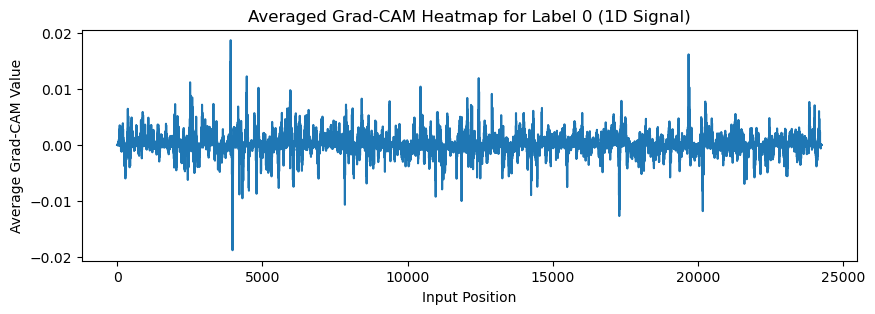

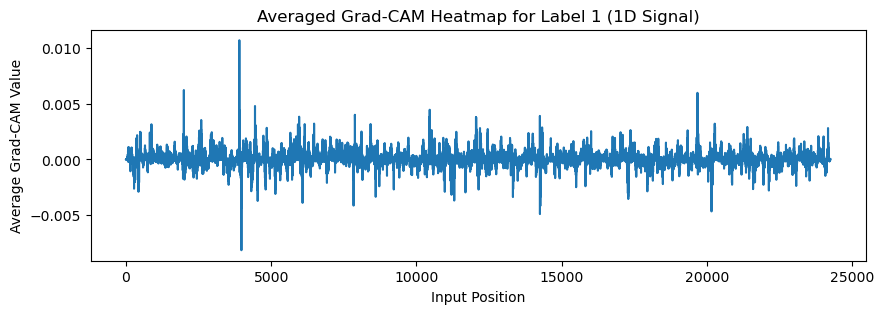

In [58]:
avg_grad_cam_0 = plot_gradCam_average(X_test, y_test, 0, loaded_model_input_nonRegress)
avg_grad_cam_1 = plot_gradCam_average(X_test,y_test,1,loaded_model_input_nonRegress)

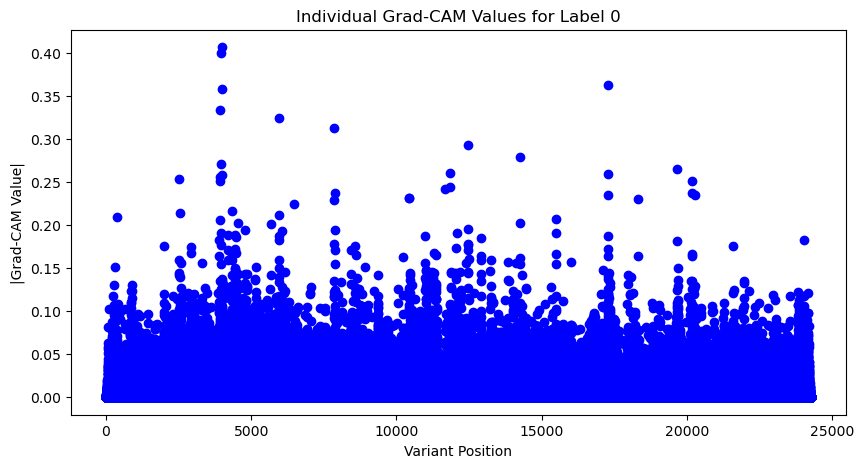

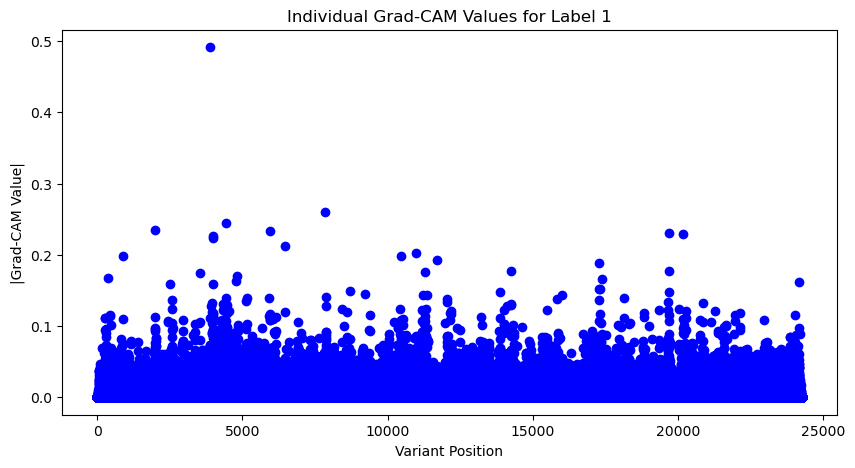

[array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([[2.7856846e-09],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]], dtype=float32),
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([[0.00000e+00],
        [0.00000e+00],
        [1.74259e-06],
        ...,
        [0.00000e+00],
        [0.00000e+00],
        [0.00000e+00]], dtype=float32),
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],

In [66]:
plot_gradCam_individual_scatter(X_test, y_test, 0, loaded_model_input_nonRegress)
plot_gradCam_individual_scatter(X_test,y_test,1,loaded_model_input_nonRegress)

In [69]:
print_top_values(df_0, avg_grad_cam_0, 500)
print_top_values(df_1, avg_grad_cam_1, 500)

Top 500 Indices: [ 1398 20871 13486  5949  6227 12922 14436 21670 19743 15404  3991 19711
  6578  5731 11168 17551 15476 12066 19346 20183  8722 17524  9361 10211
 10204  8648  5976 14338 11187 13879   448  7896   242 22332 10446 17287
  9723 14296  2527 17113  5160 11057 17961 21272 20046 16633  6924 19011
  1682   271  1995 19695 11271 16015 14933  5959 22970 21613 10452 24082
  6303 10038  9933 11824 10458 13489 21296 17271 21276 11184 20486 17460
 21599   197  6168  2051 14621 17302 24024  7652 13869  8409 12094 11384
  5211 15768  2931  2833  4522 20304 23084 11039  2772 24026 20274 10461
 12184 17960 14259  2457  5913   430  4336  4309 11375 13324 12065  2947
  7064 11294  1963 16825  4264  5304  5926  6283 17132  2316 10456 10480
  2537  4152  9378 12915   375  6149 12213 18053  5338   886 12086  7527
 15740  6148  7533  5667  6142  8916 10745 23085 18484 14015  4463 20195
  7890  8434  3323  9373  5958 14124  9363 21271  5547  4728 12468 17569
 12050 19018  6294 21926  5559  88

# CNN - regressed at input layer

In [108]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)


In [109]:
model = compile_model(len(same_SNPs_list),1)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputA (InputLayer)         [(None, 24262, 1)]        0         
                                                                 
 conv1G (Conv1D)             (None, 24232, 16)         512       
                                                                 
 batch_normalization_6 (Batc  (None, 24232, 16)        64        
 hNormalization)                                                 
                                                                 
 pool1G (MaxPooling1D)       (None, 4038, 16)          0         
                                                                 
 conv2G (Conv1D)             (None, 4024, 32)          7712      
                                                                 
 batch_normalization_7 (Batc  (None, 4024, 32)         128       
 hNormalization)                                           

/home/gdagasso/anaconda3/envs/anomalyDetectionTF/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [110]:
model_file_path = "/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/"
model_name = "cnn_1d_binaryClassifier_regressedAtInput_lr1e3_RACE"
#model_regressed = "mlp_regressed_cnn_output.h5"

cnn_model_path = model_file_path + model_name
#regressed_model_path = model_file_path + model_regressed

In [111]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 15:40:22


In [112]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{cnn_model_path}_epoch{{epoch}}_loss{{val_loss:.4f}}_acc{{val_accuracy:.4f}}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.h5"
                                                         , monitor='val_loss', verbose=2, save_best_only=True, include_optimizer=True, save_weights_only=False, mode='auto',
                                                         save_freq='epoch')

In [113]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define a learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Monitor validation loss
                              factor=0.2,          # Factor by which the learning rate will be reduced
                              patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
                              min_lr=0.00001)      # Lower bound on the learning rate


In [114]:
history = model.fit(resid_train, y_train, batch_size = 8,epochs=80, validation_data=(resid_valid,y_valid),
                    callbacks=[checkpoint_callback,reduce_lr], verbose=2) #lr_callback, checkpoint_callback, lr_callback tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),

Epoch 1/80

Epoch 1: val_loss improved from inf to 17.63385, saving model to /media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_regressedAtInput_lr1e3_RACE_epoch1_loss17.6338_acc0.7794_20240724_154023.h5
119/119 - 1s - loss: 1.5120 - accuracy: 0.8295 - precision: 0.8826 - recall: 0.8971 - val_loss: 17.6338 - val_accuracy: 0.7794 - val_precision: 0.7794 - val_recall: 1.0000 - lr: 0.0010 - 1s/epoch - 12ms/step
Epoch 2/80

Epoch 2: val_loss did not improve from 17.63385
119/119 - 1s - loss: 0.4563 - accuracy: 0.9242 - precision: 0.9374 - recall: 0.9657 - val_loss: 21.2902 - val_accuracy: 0.7794 - val_precision: 0.7794 - val_recall: 1.0000 - lr: 0.0010 - 582ms/epoch - 5ms/step
Epoch 3/80

Epoch 3: val_loss improved from 17.63385 to 12.92433, saving model to /media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_regressedAtInput_lr1e3_RACE_epoch3_loss12.9243_acc0.7794_20240724_154023.h5
119/119 - 1s - loss: 0.3515 - a

Epoch 28/80

Epoch 28: val_loss did not improve from 0.43389
119/119 - 1s - loss: 0.0426 - accuracy: 0.9989 - precision: 1.0000 - recall: 0.9986 - val_loss: 0.5520 - val_accuracy: 0.9265 - val_precision: 0.9286 - val_recall: 0.9811 - lr: 1.0000e-05 - 557ms/epoch - 5ms/step
Epoch 29/80

Epoch 29: val_loss did not improve from 0.43389
119/119 - 1s - loss: 0.0464 - accuracy: 0.9979 - precision: 0.9986 - recall: 0.9986 - val_loss: 0.5520 - val_accuracy: 0.9265 - val_precision: 0.9286 - val_recall: 0.9811 - lr: 1.0000e-05 - 584ms/epoch - 5ms/step
Epoch 30/80

Epoch 30: val_loss did not improve from 0.43389
119/119 - 1s - loss: 0.0414 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5532 - val_accuracy: 0.9265 - val_precision: 0.9286 - val_recall: 0.9811 - lr: 1.0000e-05 - 557ms/epoch - 5ms/step
Epoch 31/80

Epoch 31: val_loss did not improve from 0.43389
119/119 - 1s - loss: 0.0420 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5532 - val_accuracy

Epoch 58/80

Epoch 58: val_loss did not improve from 0.43389
119/119 - 1s - loss: 0.0333 - accuracy: 0.9989 - precision: 1.0000 - recall: 0.9986 - val_loss: 0.5844 - val_accuracy: 0.9265 - val_precision: 0.9286 - val_recall: 0.9811 - lr: 1.0000e-05 - 582ms/epoch - 5ms/step
Epoch 59/80

Epoch 59: val_loss did not improve from 0.43389
119/119 - 1s - loss: 0.0326 - accuracy: 0.9989 - precision: 0.9986 - recall: 1.0000 - val_loss: 0.5879 - val_accuracy: 0.9265 - val_precision: 0.9286 - val_recall: 0.9811 - lr: 1.0000e-05 - 574ms/epoch - 5ms/step
Epoch 60/80

Epoch 60: val_loss did not improve from 0.43389
119/119 - 1s - loss: 0.0299 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5860 - val_accuracy: 0.9265 - val_precision: 0.9286 - val_recall: 0.9811 - lr: 1.0000e-05 - 572ms/epoch - 5ms/step
Epoch 61/80

Epoch 61: val_loss did not improve from 0.43389
119/119 - 1s - loss: 0.0307 - accuracy: 0.9989 - precision: 0.9986 - recall: 1.0000 - val_loss: 0.5810 - val_accuracy

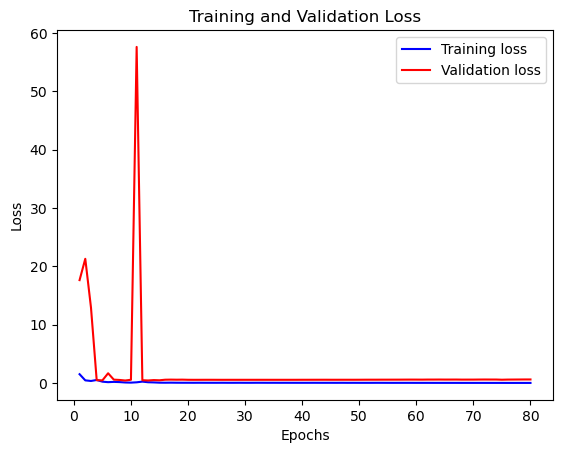

In [115]:
plot_loss(history)

In [ ]:
history_dict = history.history

In [59]:
from tensorflow.keras.models import load_model

loaded_model_input_regress = load_model("/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_regressedAtInput_lr1e3_RACE_epoch21_loss0.1641_acc0.9755_20240222_161016.h5")#""/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_noOHE_lr1e3_epoch5_loss0.5344_acc0.8725_20240216_112515.h5")#"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier.h5_epoch4_loss0.7019_acc0.7647_20240214_191738.h5")
loaded_model_input_regress.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputA (InputLayer)         [(None, 24262, 1)]        0         
                                                                 
 conv1G (Conv1D)             (None, 24232, 16)         512       
                                                                 
 batch_normalization (BatchN  (None, 24232, 16)        64        
 ormalization)                                                   
                                                                 
 pool1G (MaxPooling1D)       (None, 4038, 16)          0         
                                                                 
 conv2G (Conv1D)             (None, 4024, 32)          7712      
                                                                 
 batch_normalization_1 (Batc  (None, 4024, 32)         128       
 hNormalization)                                             

In [60]:
#predictions = loaded_model.predict(X_test)
predictions_binary = convert_preds(resid_test,loaded_model_input_regress)

#print("predictions2 ", predictions_binary.size)
#print("labels", test['PD.x'].values.size)

my_confusion_matrix(y_test,predictions_binary)

7/7 [==============================] - 0s 3ms/step
[[1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 

In [54]:
print(X_test.shape)
print(y_test[:10])

(204, 24262, 1)
[1. 1. 1. 0. 0. 0. 0. 1. 1. 1.]


[1.]


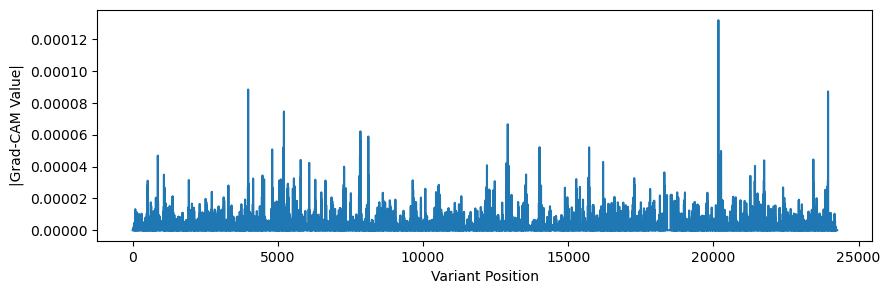

(1, 24262, 1)
(1, 24262, 1)
[[[-0.]
  [ 0.]
  [-0.]
  ...
  [ 0.]
  [ 0.]
  [ 0.]]]
[1.]


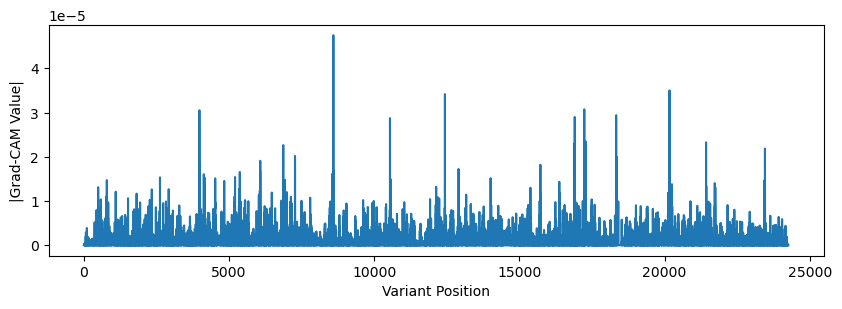

(1, 24262, 1)
(1, 24262, 1)
[[[ 1.7169087e-08]
  [-0.0000000e+00]
  [-0.0000000e+00]
  ...
  [-0.0000000e+00]
  [ 0.0000000e+00]
  [-0.0000000e+00]]]
[0.]


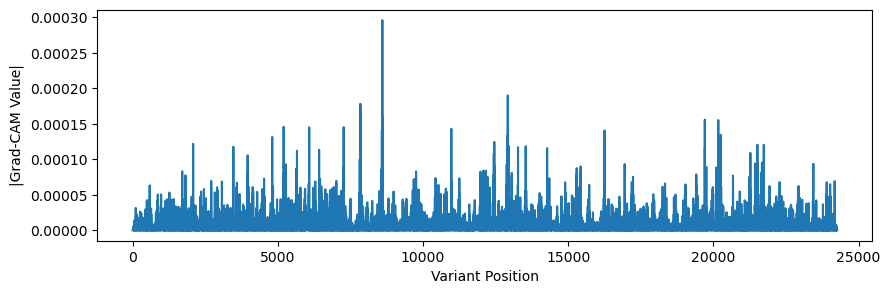

(1, 24262, 1)
(1, 24262, 1)
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[0.]


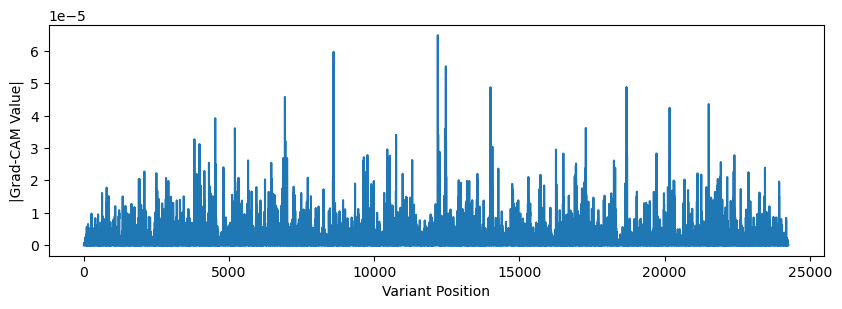

(1, 24262, 1)
(1, 24262, 1)
[[[ 0.]
  [-0.]
  [-0.]
  ...
  [ 0.]
  [ 0.]
  [ 0.]]]


In [61]:
grad_cam_1 = plot_gradCam(resid_test,y_test,0,loaded_model_input_regress)
grad_cam_2 = plot_gradCam(resid_test,y_test,1,loaded_model_input_regress)
grad_cam_3 = plot_gradCam(resid_test,y_test,4,loaded_model_input_regress)
grad_cam_4 = plot_gradCam(resid_test,y_test,5,loaded_model_input_regress)

In [55]:
reshaped_X_resid = np.squeeze(resid_test, axis=2)

In [56]:
X_resid_df = pd.DataFrame(reshaped_X_resid, columns=df_1.columns, index = ids_test)

In [57]:
print_peaks(X_resid_df, grad_cam_4, threshold = 0.005)

12187
[ 0. -0. -0. ...  0.  0.  0.]
Peak Indices: []
VEP:



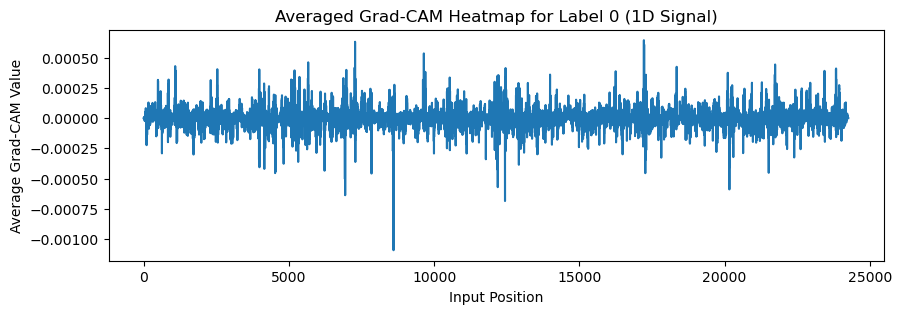

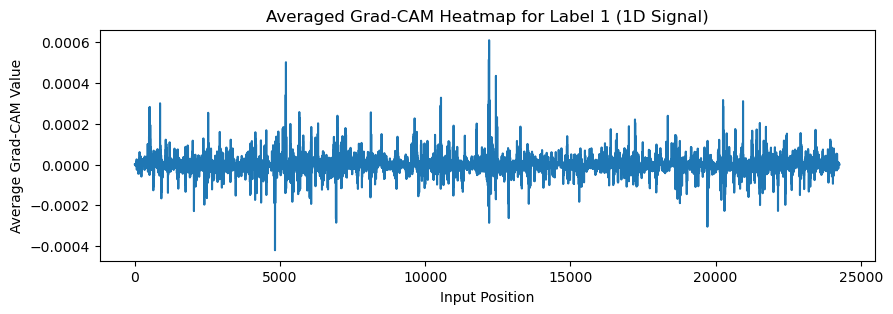

In [62]:
avg_grad_cam_0 = plot_gradCam_average(resid_test, y_test, 0, loaded_model_input_regress)
avg_grad_cam_1 = plot_gradCam_average(resid_test,y_test,1,loaded_model_input_regress)

In [59]:
print_peaks(X_resid_df, avg_grad_cam_0, threshold = 0.0004)
print_peaks(X_resid_df, avg_grad_cam_1, threshold = 0.0004)

17222
[-1.0297482e-08 -1.2987263e-08 -9.4521422e-09 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
Peak Indices: [ 1083  2533  3978  3984  4152  4524  4535  5663  6226  6926  6936  7267
  7270  7277  7836  7843  8587  8591  8598  8601  9645 12187 12190 12440
 12459 17222 17231 17271 18351 20162 20167 21521 21741 23836 23840]
Peak Index: 1083
Column Name: rs4689183
Grad-CAM Value: 0.0004301593
Peak Index: 2533
Column Name: rs480510
Grad-CAM Value: 0.00040469322
Peak Index: 3978
Column Name: rs13131355
Grad-CAM Value: 0.00040322824
Peak Index: 3984
Column Name: rs11731852
Grad-CAM Value: -0.0004064321
Peak Index: 4152
Column Name: rs4234993
Grad-CAM Value: -0.0004200808
Peak Index: 4524
Column Name: rs1491231
Grad-CAM Value: -0.000454863
Peak Index: 4535
Column Name: rs9654324
Grad-CAM Value: -0.00044130406
Peak Index: 5663
Column Name: rs13103573
Grad-CAM Value: 0.0004617172
Peak Index: 6226
Column Name: chr4:47019621
Grad-CAM Value: -0.00043508637
Peak Index: 6926
Column Name: rs11

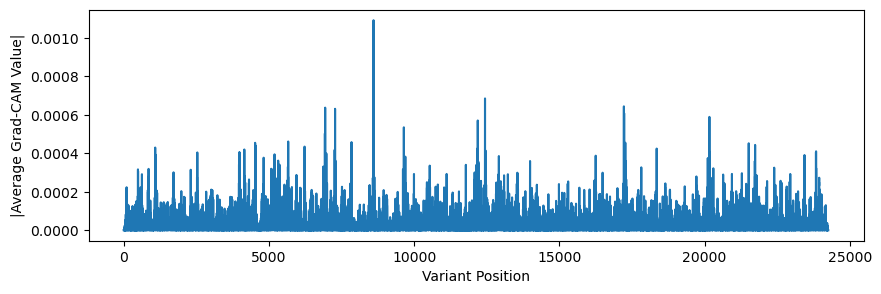

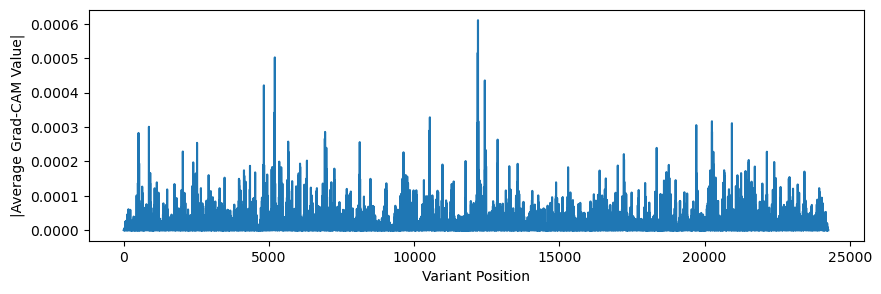

In [65]:
avg_grad_cam_0 = plot_gradCam_average_manPlot(resid_test, y_test, 0, loaded_model_input_regress)
avg_grad_cam_1 = plot_gradCam_average_manPlot(resid_test,y_test,1,loaded_model_input_regress)

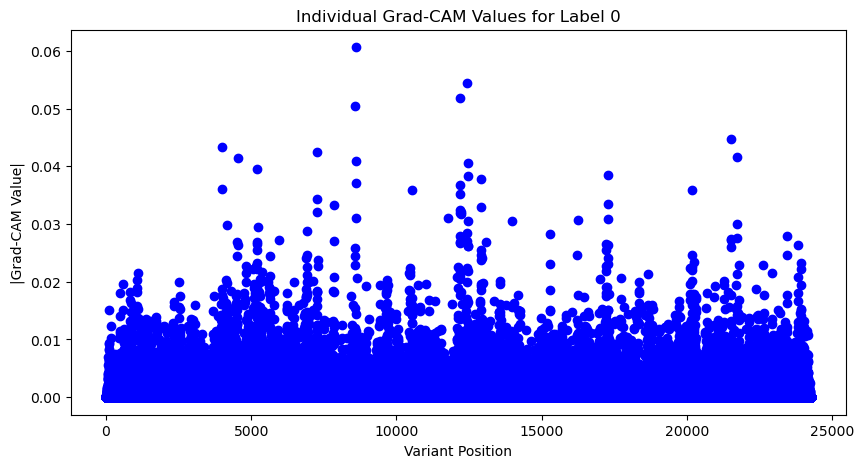

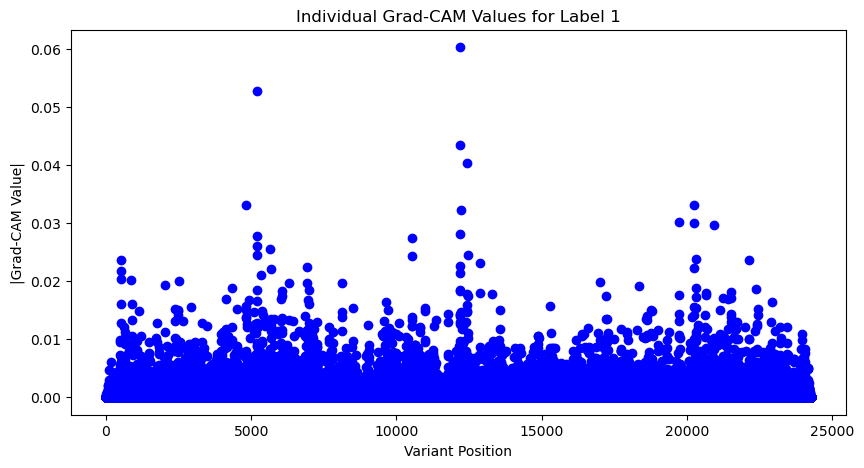

[array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([[1.7169087e-08],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]], dtype=float32),
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([[0.0000000e+00],
        [0.0000000e+00],
        [1.6010469e-11],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]], dtype=float32),
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
 

In [66]:
plot_gradCam_individual_scatter(resid_test, y_test, 0, loaded_model_input_regress)
plot_gradCam_individual_scatter(resid_test,y_test,1,loaded_model_input_regress)

In [74]:
print_top_values(df_0, avg_grad_cam_0, 500)
print_top_values(df_1, avg_grad_cam_1, 500)

Top 500 Indices: [ 5191  3948  8645  1067  8793  1691 12316  4822  5249 12213 21527 12463
 13372  3226  2307 12417 13764 17256  4780 23435  5715 15127 20688 18656
  7518  8452  4526  2090  7146  3726  5625 23654 22410  2990 14195  6237
  8930 10629 17697  3668  2077  2339 12884  5376 20273 21877 22480  5079
 12445  5464 16744  6924  4472 18560  4759  4276 22431   865 16465 17916
 18685  7505  6519 20243 23936 12198  4884   485  7263 14240 10511  4011
 10510  8570 18659  3996 19809  5624  3998 16260 22660 14063  2498 23433
  7514 13520 13987 23436 21111  5203 11316  3224 15301 17721 12262 18295
 13510 13507  2997  9048 12922  5651  3985 14022  5183 20183 10784 19597
 14622 24026 16637  4153 16386  7802  7275 15167 20253 16392  4760 11129
 21217 23155 20638 17233 12818 10463 15302  4531 14190  6487 17703 13271
 23839  9989 14201  6633 15092  4309   848  7281  9778 19725 15170  1149
  9668  5072  4481 20155 15093  5314 11326  2482 18344 23455  6466 20976
  6898 17227   849 23825   834  94

In [63]:
print(y_test)

[1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1.
 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1.
 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0.]


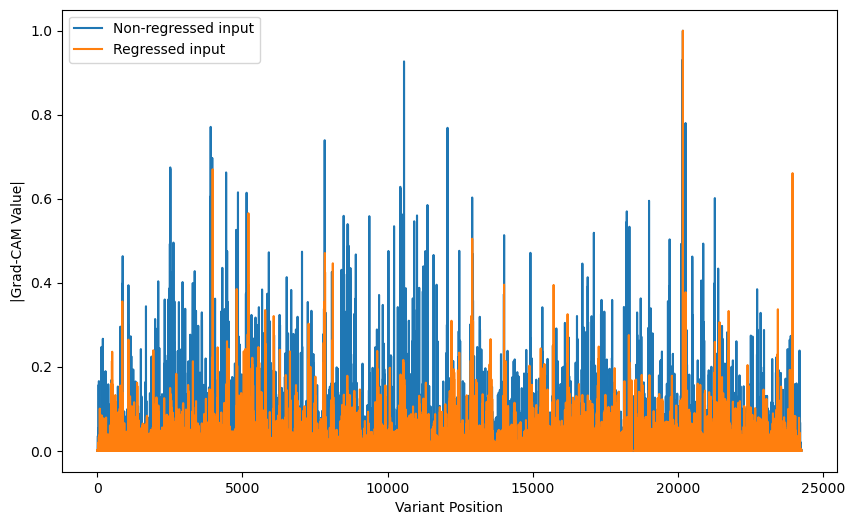

(array([[[ 0.],
         [ 0.],
         [-0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]]], dtype=float32),
 array([[[-0.],
         [ 0.],
         [-0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]]], dtype=float32))

In [67]:
plot_gradCam_ind_overlay(X_test, resid_test, y_test, 0, loaded_model_input_nonRegress, loaded_model_input_regress )

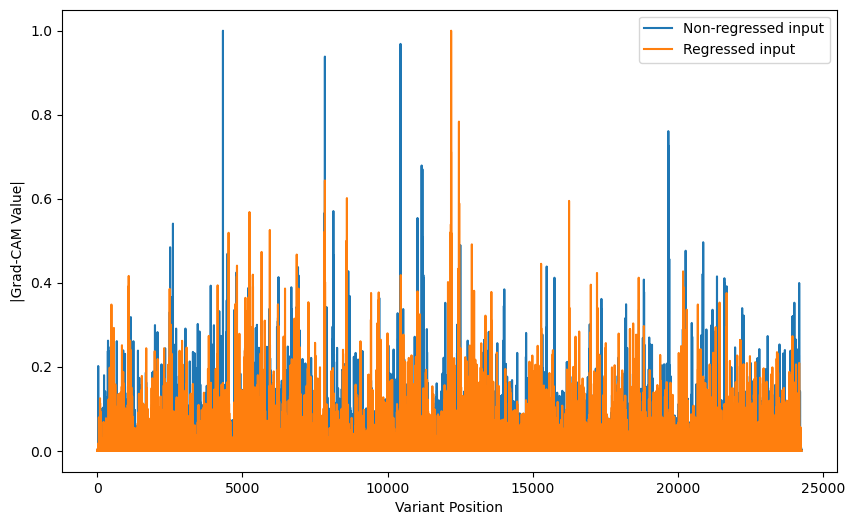

(array([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]], dtype=float32),
 array([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]], dtype=float32))

In [68]:
plot_gradCam_ind_overlay(X_test, resid_test, y_test, 3, loaded_model_input_nonRegress, loaded_model_input_regress)